# Part 2: Transfer Learning for CNNs

In this section we will use the weights of the previously trained model to fine-tune a new model on a different dataset. This is called transfer learning, and it can be used to speed up training and improve performance on new tasks.

In practice, the new model weights are initialized with the existing model's weights, but the classifier (the fully connected neural network) is replaced with a new one that is trained for the new task. This allows the model to learn the new task faster and with less data, while still benefiting from the existing model's capabilities.

The custom dataset on which the model will be retrained is imagse and icons of chess pieces.

Each class in the dataset is a type of chess piece: King, Queen, Bishop, Knight, Rook, Pawn.
The task is to classify the pieces into their respective types using a CNN.

# Environment and Dataset Setup

In [102]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import cv2
import utils
import downloader
from pathlib import Path
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns

There are several stages to assembling the dataset, as it is comprised of two separate small such datasets from Kaggle. They are independently downloaded and then combined locally.

The script for downloading and merging the datasets is provided in a separate file and is merely invoked here for convenience.

Dataset one downloaded to: /home/sean/.cache/kagglehub/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset/versions/31
Dataset two downloaded to: /home/sean/.cache/kagglehub/datasets/niteshfre/chessman-image-dataset/versions/1/Chessman-image-dataset/Chess
data/
	merged_chess_dataset/
		bishop/  (227 images)
		king/  (75 images)
		knight/  (280 images)
		pawn/  (188 images)
		queen/  (192 images)
		rook/  (241 images)

Class: bishop


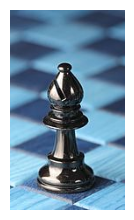


Class: king


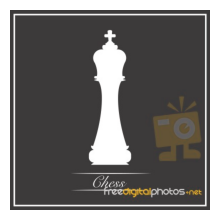


Class: knight


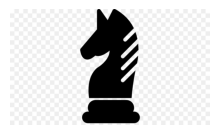


Class: pawn


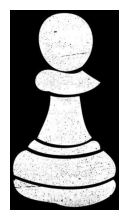


Class: queen


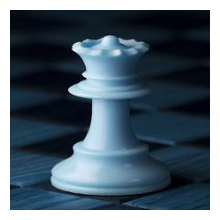


Class: rook


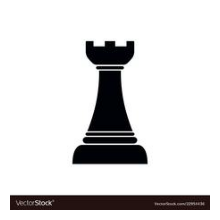

In [53]:
downloader.download_dataset()

data_root = Path("../data/merged_chess_dataset")
for cls_dir in sorted(p for p in data_root.iterdir() if p.is_dir()):
    print(f"\nClass: {cls_dir.name}")

    images = sorted(cls_dir.glob("*"))[:1]
    for img_path in images:
        img = cv2.imread(str(img_path))
        if img is None:
            continue  # skip unreadable images
        utils.display_image(img)

## Dataloader Creation

In [54]:
data_transforms = transforms.Compose([
    # Resize to 32x32 to match the model's input
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Same normalization stats we used during CIFAR-10 training
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
])

full_dataset = datasets.ImageFolder(root='../data/merged_chess_dataset', transform=data_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

# Check classes
class_names = full_dataset.classes
print(f"Detected classes: {class_names}")
print(f"Training images: {len(train_data)}, Validation images: {len(val_data)}")

Detected classes: ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
Training images: 962, Validation images: 241


## Model Import and Definition

A 'Deeper Wide CNN' model with batch normalization from the previous notebook, which has achieved 90% accuracy on CIFAR-10, is redefined here for custom training.

In [55]:
class DW_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 32x32x3 in -> 16x16x16 out
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1a = nn.BatchNorm2d(32)
        self.bn1b = nn.BatchNorm2d(32)

        # Block 2: 16x16x16 in -> 8x8x32 out
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2a = nn.BatchNorm2d(64)
        self.bn2b = nn.BatchNorm2d(64)

        # Block 3 : 8x8x32 in -> 4x4x64 out
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3a = nn.BatchNorm2d(128)
        self.bn3b = nn.BatchNorm2d(128)

        # Classifier
        self.fc1 = nn.Linear(4 * 4 * 128, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = self.pool1(F.relu(self.bn1b(self.conv1b(x))))

        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = self.pool2(F.relu(self.bn2b(self.conv2b(x))))

        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = self.pool3(F.relu(self.bn3b(self.conv3b(x))))

        # Classifier
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Loading the previous model weights from file:

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DW_CNN().to(device)
model.load_state_dict(torch.load("../models/model_weights.pth", map_location=device))
print("Successfully loaded CIFAR-10 model from file.")

Successfully loaded CIFAR-10 model from file.


Now the model's classifier is redefined for custom training.

In [57]:
num_classes = len(full_dataset.classes)
model.fc2 = torch.nn.Linear(model.fc2.in_features, num_classes).to(device)

## Training

Fine-tuning the model for chess piece classifications is done by two stages:

1. Warming up the classifier, by freezing the model's convolutional layers and training only the classifier (the 'head'), which has just been defined above.
2. Unfreezing the convolutional layers and training the entire model to specialize on the new dataset with a tiny learning rate.

#### 1. Warming up

Since just one layer of hidden neurons is being trained, we use a simple Adam optimizer with a small learning rate.

But first, we need to redefine the previously used evaluate() and train_CNN() functions.

In [58]:
def evaluate(model, testloader, criterion, device):
    model.eval()  # Set to evaluation mode (turns off Dropout/BatchNorm)
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No gradient calculation saved (saves memory)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    loss = test_loss / len(testloader)
    acc = 100. * correct / len(testloader.dataset)
    return loss, acc

In [59]:
def train_CNN(model, trainloader, valloader, criterion, optimizer, device, epochs=5,
               console=False, early_stopping=False, patience=3, scheduler=None):
    model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    best_val_loss = float('inf') # For early stopping
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improvement_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler:
          scheduler.step()

        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        epoch_val_loss, epoch_val_acc = evaluate(model, valloader, criterion, device)

        # Save to history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        if console:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")

        if early_stopping:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                # Save the best model weights
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improvement_counter = 0 # Reset counter
            else:
                no_improvement_counter += 1
                if console: print(f"  EarlyStopping counter: {no_improvement_counter} out of {patience}")

                if no_improvement_counter >= patience:
                    if console: print("Early stopping triggered! Restoring best weights...")
                    model.load_state_dict(best_model_wts) # Restore best model
                    break

    if console: print("Finished Training")
    return history

Now the base of the model is frozen and the new head is unfrozen and trained. We use a regular Adam optimizer with a larger than normal learning rate - 0.005. This is because we aim to train just the two layers of the classifier for a handful of epochs.

(We can see the number of total parameters in the model vs the ones unfrozen for training below)

In [60]:
# Freeze the base
for param in model.parameters():
    param.requires_grad = False

# Unfreeze fc1 and fc2
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc2.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, console=True)

Total Parameters: 550,950
Trainable Parameters: 263,046
Epoch 1/5 | Train Loss: 1.7111 | Train Acc: 27.75% | Val Loss: 1.5127 | Val Acc: 44.81%
Epoch 2/5 | Train Loss: 1.5312 | Train Acc: 40.75% | Val Loss: 1.4453 | Val Acc: 46.89%
Epoch 3/5 | Train Loss: 1.4946 | Train Acc: 42.62% | Val Loss: 1.4326 | Val Acc: 45.23%
Epoch 4/5 | Train Loss: 1.4545 | Train Acc: 43.66% | Val Loss: 1.4253 | Val Acc: 49.38%
Epoch 5/5 | Train Loss: 1.4436 | Train Acc: 43.56% | Val Loss: 1.4036 | Val Acc: 50.62%
Finished Training


Our warming-up phase showed some improvement in validation accuracy, but it is far from over. 50% accuracy is a good baseline for a problem with 6 classes, as the random guessing accuracy for a 6-class problem is 16.67%.

Including the warm-up phase is important because otherwise the model would have met very sharp gradients when it was retrained for the new dataset, which would have led to a loss of accuracy.

We will now unfreeze the entire classifier and train it for a few more epochs, to see if this leads to improvement.

In [65]:
for param in model.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Now training {trainable:,} parameters.")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
cos_scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=30, console=True, early_stopping=True, patience=3, scheduler=cos_scheduler)

Now training 550,950 parameters.
Epoch 1/30 | Train Loss: 0.6089 | Train Acc: 80.15% | Val Loss: 0.7990 | Val Acc: 69.71%
Epoch 2/30 | Train Loss: 0.4708 | Train Acc: 84.72% | Val Loss: 0.7652 | Val Acc: 73.86%
Epoch 3/30 | Train Loss: 0.4228 | Train Acc: 87.73% | Val Loss: 0.7515 | Val Acc: 72.61%
Epoch 4/30 | Train Loss: 0.3789 | Train Acc: 89.60% | Val Loss: 0.7278 | Val Acc: 73.03%
Epoch 5/30 | Train Loss: 0.3050 | Train Acc: 91.58% | Val Loss: 0.7248 | Val Acc: 72.20%
Epoch 6/30 | Train Loss: 0.2876 | Train Acc: 92.52% | Val Loss: 0.6983 | Val Acc: 74.69%
Epoch 7/30 | Train Loss: 0.2608 | Train Acc: 94.70% | Val Loss: 0.7011 | Val Acc: 75.52%
  EarlyStopping counter: 1 out of 3
Epoch 8/30 | Train Loss: 0.2186 | Train Acc: 96.26% | Val Loss: 0.7123 | Val Acc: 73.86%
  EarlyStopping counter: 2 out of 3
Epoch 9/30 | Train Loss: 0.1958 | Train Acc: 96.26% | Val Loss: 0.6998 | Val Acc: 74.27%
  EarlyStopping counter: 3 out of 3
Early stopping triggered! Restoring best weights...
Finish

It is apparent from the logs that the model is overfitting significantly, because the training accuracy rose to 96% while the validation accuracy only reached 74%.

This can also be seen in the training curves:

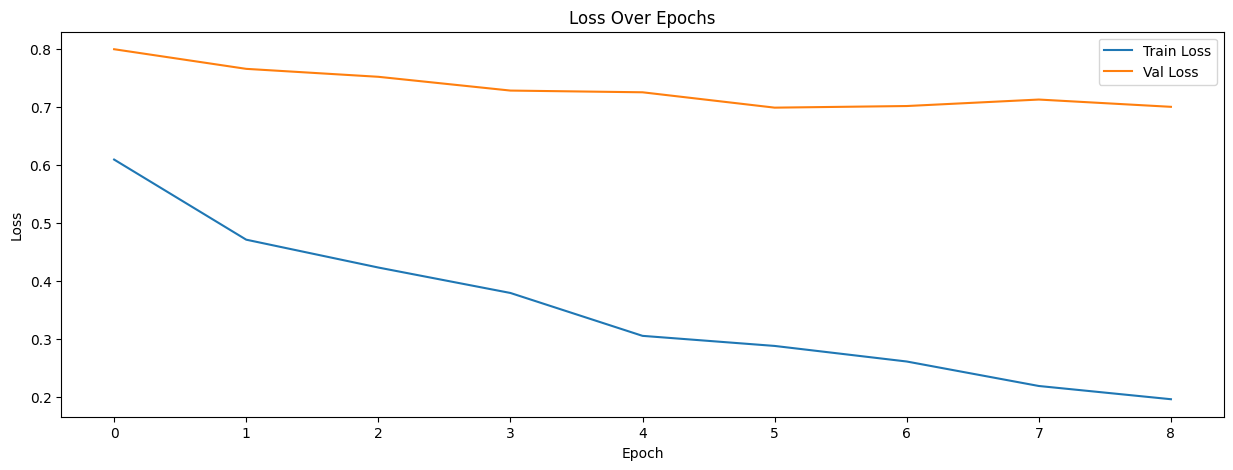

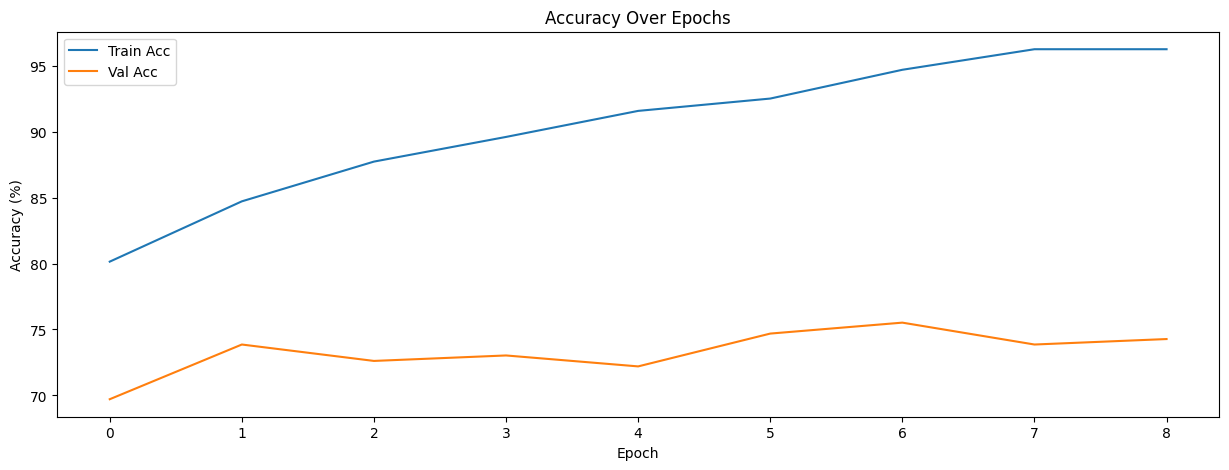

In [66]:
utils.plot_loss(results['train_loss'], results['val_loss'])
utils.plot_acc(results['train_acc'], results['val_acc'])

The validation accuracy barely rises at all, and the loss gap widens significantly. This is a clear sign of overfitting, and we will need to adjust our approach to prevent it.

The main method of dealing with this will be via data augmentation.

## Data Augmentation

We shall redefine our training set dataloader with an aggressive augmentation transformation.

In [88]:
aug_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5), # Bishops/Rooks look the same flipped
    transforms.RandomRotation(10),          # Keep it subtle (max 10 degrees)
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Very slight light shifts
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
])

full_dataset = datasets.ImageFolder(root='../data/merged_chess_dataset', transform=aug_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

## Second Attempt

This time, the number of echoes is reduced to 8, since anything beyond that would just risk overfitting.

In [92]:
model = DW_CNN().to(device)
model.load_state_dict(torch.load("../models/model_weights.pth", map_location=device))
print("Successfully loaded CIFAR-10 model from file.")

model.fc2 = torch.nn.Linear(model.fc2.in_features, num_classes).to(device)

Successfully loaded CIFAR-10 model from file.


In [93]:
# Freeze the base
for param in model.parameters():
    param.requires_grad = False

# Unfreeze fc1 and fc2
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc2.parameters(), lr=0.005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, console=True)

Total Parameters: 550,950
Trainable Parameters: 263,046
Epoch 1/5 | Train Loss: 1.7498 | Train Acc: 24.53% | Val Loss: 1.6862 | Val Acc: 26.97%
Epoch 2/5 | Train Loss: 1.5573 | Train Acc: 38.25% | Val Loss: 1.6513 | Val Acc: 35.27%
Epoch 3/5 | Train Loss: 1.5322 | Train Acc: 42.41% | Val Loss: 1.6651 | Val Acc: 34.44%
Epoch 4/5 | Train Loss: 1.5097 | Train Acc: 40.96% | Val Loss: 1.5995 | Val Acc: 36.10%
Epoch 5/5 | Train Loss: 1.5174 | Train Acc: 41.89% | Val Loss: 1.5670 | Val Acc: 40.25%
Finished Training


In [94]:
for param in model.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Now training {trainable:,} parameters.")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
cos_scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, console=True, early_stopping=True, patience=3, scheduler=cos_scheduler)

Now training 550,950 parameters.
Epoch 1/15 | Train Loss: 1.3893 | Train Acc: 47.92% | Val Loss: 1.3980 | Val Acc: 44.40%
Epoch 2/15 | Train Loss: 1.1824 | Train Acc: 57.48% | Val Loss: 1.2864 | Val Acc: 53.11%
Epoch 3/15 | Train Loss: 1.0413 | Train Acc: 64.35% | Val Loss: 1.2172 | Val Acc: 55.19%
Epoch 4/15 | Train Loss: 0.9587 | Train Acc: 67.98% | Val Loss: 1.1652 | Val Acc: 55.60%
Epoch 5/15 | Train Loss: 0.8796 | Train Acc: 71.41% | Val Loss: 1.1243 | Val Acc: 58.92%
Epoch 6/15 | Train Loss: 0.8375 | Train Acc: 71.83% | Val Loss: 1.0899 | Val Acc: 58.92%
Epoch 7/15 | Train Loss: 0.7997 | Train Acc: 73.60% | Val Loss: 1.0673 | Val Acc: 59.75%
Epoch 8/15 | Train Loss: 0.8050 | Train Acc: 75.16% | Val Loss: 1.0133 | Val Acc: 67.22%
Epoch 9/15 | Train Loss: 0.7148 | Train Acc: 75.36% | Val Loss: 1.0082 | Val Acc: 64.32%
Epoch 10/15 | Train Loss: 0.6952 | Train Acc: 77.44% | Val Loss: 1.0071 | Val Acc: 65.56%
Epoch 11/15 | Train Loss: 0.7249 | Train Acc: 76.20% | Val Loss: 1.0427 | Va

Our model still overfits, and now the problem is even worse as the data augmentation made it harder for it to understand and generalize the patterns in the chess images. This highlights the importance of careful data selection and tuning.

We can still attempt to deal with this issue by adding dropout to the initial model.

## Modified Model with Dropout

In [95]:
class DW_CNN2(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.5):
        super().__init__()

        # Block 1
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1a = nn.BatchNorm2d(32)
        self.bn1b = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout2d(0.2)

        # Block 2
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2a = nn.BatchNorm2d(64)
        self.bn2b = nn.BatchNorm2d(64)
        self.drop2 = nn.Dropout2d(0.3)

        # Block 3
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3a = nn.BatchNorm2d(128)
        self.bn3b = nn.BatchNorm2d(128)
        self.drop3 = nn.Dropout2d(0.3)

        # Classifier
        self.fc1 = nn.Linear(4 * 4 * 128, 128)
        self.dropout_fc = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        x = self.drop3(x)

        # Classifier
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x


## Third Attempt

In [96]:
model = DW_CNN2().to(device)
model.load_state_dict(torch.load("../models/model_weights.pth", map_location=device))
print("Successfully loaded CIFAR-10 model from file.")

model.fc2 = torch.nn.Linear(model.fc2.in_features, num_classes).to(device)

Successfully loaded CIFAR-10 model from file.


In [97]:
# Freeze the base
for param in model.parameters():
    param.requires_grad = False

# Unfreeze fc1 and fc2
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc2.parameters(), lr=0.005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, console=True)

Total Parameters: 550,950
Trainable Parameters: 263,046
Epoch 1/5 | Train Loss: 1.9373 | Train Acc: 23.60% | Val Loss: 1.7131 | Val Acc: 24.90%
Epoch 2/5 | Train Loss: 1.7855 | Train Acc: 23.80% | Val Loss: 1.7152 | Val Acc: 31.54%
Epoch 3/5 | Train Loss: 1.7936 | Train Acc: 23.91% | Val Loss: 1.7394 | Val Acc: 24.48%
Epoch 4/5 | Train Loss: 1.7846 | Train Acc: 23.28% | Val Loss: 1.7409 | Val Acc: 25.31%
Epoch 5/5 | Train Loss: 1.7787 | Train Acc: 22.66% | Val Loss: 1.7307 | Val Acc: 20.33%
Finished Training


In [99]:
for param in model.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Now training {trainable:,} parameters.")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, console=True, early_stopping=True, patience=3)

Now training 550,950 parameters.
Epoch 1/15 | Train Loss: 1.4248 | Train Acc: 42.72% | Val Loss: 1.4358 | Val Acc: 50.62%
Epoch 2/15 | Train Loss: 1.4363 | Train Acc: 46.67% | Val Loss: 1.4121 | Val Acc: 47.72%
Epoch 3/15 | Train Loss: 1.3746 | Train Acc: 47.71% | Val Loss: 1.3960 | Val Acc: 53.53%
Epoch 4/15 | Train Loss: 1.3376 | Train Acc: 49.79% | Val Loss: 1.3537 | Val Acc: 49.38%
Epoch 5/15 | Train Loss: 1.2717 | Train Acc: 53.22% | Val Loss: 1.3302 | Val Acc: 55.60%
Epoch 6/15 | Train Loss: 1.2806 | Train Acc: 51.25% | Val Loss: 1.2615 | Val Acc: 56.02%
Epoch 7/15 | Train Loss: 1.2570 | Train Acc: 52.81% | Val Loss: 1.2313 | Val Acc: 58.92%
Epoch 8/15 | Train Loss: 1.1561 | Train Acc: 57.59% | Val Loss: 1.2280 | Val Acc: 58.92%
Epoch 9/15 | Train Loss: 1.1652 | Train Acc: 55.51% | Val Loss: 1.1616 | Val Acc: 62.24%
Epoch 10/15 | Train Loss: 1.1533 | Train Acc: 57.07% | Val Loss: 1.1457 | Val Acc: 63.07%
Epoch 11/15 | Train Loss: 1.0772 | Train Acc: 59.25% | Val Loss: 1.1404 | Va

This actually worked reasonably well. The accuracy is low, but it didn't overfit. We can attempt to continue training to get a higher result.

In [100]:
results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, console=True, early_stopping=True, patience=3)

Epoch 1/15 | Train Loss: 0.9816 | Train Acc: 65.18% | Val Loss: 1.0555 | Val Acc: 65.15%
Epoch 2/15 | Train Loss: 0.9517 | Train Acc: 66.22% | Val Loss: 1.0099 | Val Acc: 65.98%
Epoch 3/15 | Train Loss: 0.8956 | Train Acc: 67.98% | Val Loss: 0.9979 | Val Acc: 66.80%
Epoch 4/15 | Train Loss: 0.9103 | Train Acc: 67.36% | Val Loss: 0.9596 | Val Acc: 67.63%
Epoch 5/15 | Train Loss: 0.8936 | Train Acc: 67.98% | Val Loss: 0.9173 | Val Acc: 68.88%
Epoch 6/15 | Train Loss: 0.8576 | Train Acc: 69.44% | Val Loss: 0.9301 | Val Acc: 69.71%
  EarlyStopping counter: 1 out of 3
Epoch 7/15 | Train Loss: 0.9034 | Train Acc: 68.61% | Val Loss: 0.9320 | Val Acc: 69.29%
  EarlyStopping counter: 2 out of 3
Epoch 8/15 | Train Loss: 0.8414 | Train Acc: 67.36% | Val Loss: 0.9239 | Val Acc: 68.88%
  EarlyStopping counter: 3 out of 3
Early stopping triggered! Restoring best weights...
Finished Training


We have reached a final validation accuracy of 68.8%. We solved overfitting, but at the cost of harming the model's validation accuracy. If we were to test this with a separate testing subset we would have gotten a slightly lower accuracy, but it's still not great. We are severely hampered by the lack of data and the complexity of the task.

### Confusion Matrix

Part of the challenge in the chess dataset is that the pieces are very similar to eachother. To understand which pieces are the hardest for the model to distinguish we can generate a confusion matrix.

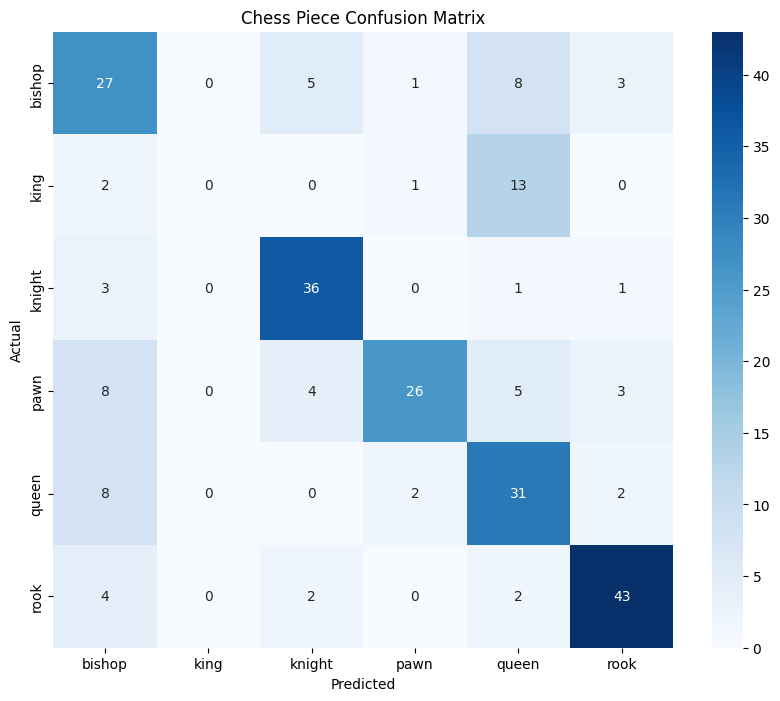

In [104]:
def get_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

y_true, y_pred = get_confusion_matrix(model, val_loader, device)

# Build the matrix
classes = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Chess Piece Confusion Matrix')
plt.show()

Here we can see the main source of the confusion: while most pieces were assigned correctly, the model completely ignored the king class, and classified all kings as queens. This is likely due to the small number of king images in the dataset, and the similarity between the king and queen pieces.

Because out of 1200 images only 75 are images of kings, the model learned that it is better off statistically 'giving up' on the kings and classifying them as queens rather than trying to learn to classify that class for such a small amount of examples.

This can be fixed by giving the kings class a higher weight in the loss function:

In [110]:
weights = torch.tensor([1.0, 2.0, 1.0, 1.0, 1.0, 1.0]).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

In [106]:
model = DW_CNN2().to(device)
model.load_state_dict(torch.load("../models/model_weights.pth", map_location=device))
print("Successfully loaded CIFAR-10 model from file.")

model.fc2 = torch.nn.Linear(model.fc2.in_features, num_classes).to(device)

Successfully loaded CIFAR-10 model from file.


In [111]:
# Freeze the base
for param in model.parameters():
    param.requires_grad = False

# Unfreeze fc1 and fc2
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc2.parameters(), lr=0.005, weight_decay=1e-5)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, console=True)

Total Parameters: 550,950
Trainable Parameters: 263,046
Epoch 1/5 | Train Loss: 1.3425 | Train Acc: 45.74% | Val Loss: 1.2756 | Val Acc: 52.70%
Epoch 2/5 | Train Loss: 1.3763 | Train Acc: 49.06% | Val Loss: 1.2666 | Val Acc: 48.96%
Epoch 3/5 | Train Loss: 1.3147 | Train Acc: 50.10% | Val Loss: 1.2596 | Val Acc: 48.96%
Epoch 4/5 | Train Loss: 1.3499 | Train Acc: 50.42% | Val Loss: 1.2450 | Val Acc: 48.13%
Epoch 5/5 | Train Loss: 1.3312 | Train Acc: 49.27% | Val Loss: 1.2185 | Val Acc: 57.26%
Finished Training


In [112]:
for param in model.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Now training {trainable:,} parameters.")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

results = train_CNN(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, console=True, early_stopping=True, patience=3)

Now training 550,950 parameters.
Epoch 1/15 | Train Loss: 1.2797 | Train Acc: 51.77% | Val Loss: 1.2145 | Val Acc: 56.02%
Epoch 2/15 | Train Loss: 1.2237 | Train Acc: 56.13% | Val Loss: 1.1619 | Val Acc: 62.24%
Epoch 3/15 | Train Loss: 1.1974 | Train Acc: 55.30% | Val Loss: 1.1586 | Val Acc: 61.00%
Epoch 4/15 | Train Loss: 1.2024 | Train Acc: 56.55% | Val Loss: 1.1722 | Val Acc: 60.17%
  EarlyStopping counter: 1 out of 3
Epoch 5/15 | Train Loss: 1.1160 | Train Acc: 56.76% | Val Loss: 1.1009 | Val Acc: 62.24%
Epoch 6/15 | Train Loss: 1.0735 | Train Acc: 59.67% | Val Loss: 1.0966 | Val Acc: 63.07%
Epoch 7/15 | Train Loss: 1.1531 | Train Acc: 56.65% | Val Loss: 1.0946 | Val Acc: 62.66%
Epoch 8/15 | Train Loss: 1.0660 | Train Acc: 63.83% | Val Loss: 1.0875 | Val Acc: 63.07%
Epoch 9/15 | Train Loss: 1.0311 | Train Acc: 61.95% | Val Loss: 1.0597 | Val Acc: 64.73%
Epoch 10/15 | Train Loss: 0.9887 | Train Acc: 65.07% | Val Loss: 1.0333 | Val Acc: 63.07%
Epoch 11/15 | Train Loss: 1.0064 | Train

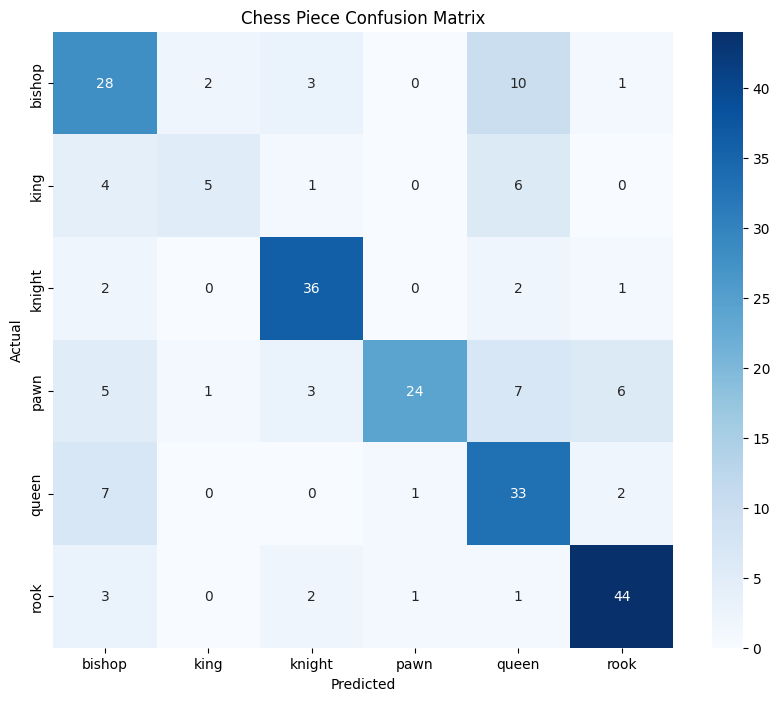

In [113]:
def get_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

y_true, y_pred = get_confusion_matrix(model, val_loader, device)

# Build the matrix
classes = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Chess Piece Confusion Matrix')
plt.show()

The weighting might have indeed convinced the model to focus more on the king class, but it caused it to miscategorize other classes, and overall the validation accuracy dropped from 68% to 62%. Although the king is the most important piece in chess, we aim to categorize all pieces correctly, so this is not an improvement.

## Conclusions

In this notebook we have seen how to use transfer learning to solve a classification problem with a small dataset. We met a significant challenge in this dataset as it was too small to provide our model with enough examples to learn from. This is a common problem in machine learning, and it is why transfer learning is so important. By using a pre-trained model, we were able to leverage the knowledge it had already learned from a larger dataset, and apply it to our smaller dataset. This allowed us to achieve a validation accuracy of 68%, which is far from ideal, but quite good for such a small dataset.